# `sklearn-mrmr` demo and comparison

This notebooks integrates `sklearn-mrmr` into `sklearn`'s pipelines, cross-validation, and hyperparameter optimization. 

**The number of features to select is a tunable parameter!**

It also compares the performance of a regression model with MRMR to one without feature selection on the same dataset.

**Table of Contents**

1. Regression task with random forest
    - Data
    - Pipeline without feature selection
    - Pipeline with MRMR feature selection
    - Examine results
2. Classification task with logistic regression
    - Data
    - Pipeline without feature selection
    - Pipeline with MRMR feature selection
    - Examine results

In [45]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('sklearn-mrmr'))
from mrmr import MRMRFeatureSelector


## Regression task with random forest

### Data

This dataset is available at https://www.key2stats.com/data-set/view/190 

In [46]:
irt = pd.read_csv('~/Downloads/rwm1984_190_27.csv')
irt = irt.drop(['Unnamed: 0', 'X'], axis=1)
irt.head()

,docvis,hospvis,edlevel,age,outwork,female,married,kids,hhninc,educ,self,edlevel1,edlevel2,edlevel3,edlevel4
0,1,0,3,54,0,0,1,0,3.050,15.0,0,0,0,1,0
1,0,0,1,44,1,1,1,0,3.050,9.0,0,1,0,0,0
2,0,0,1,58,1,1,0,0,1.434,11.0,0,1,0,0,0
3,7,2,1,64,0,0,0,0,1.500,10.5,0,1,0,0,0
4,6,0,3,30,1,0,0,0,2.400,13.0,0,0,0,1,0


In [47]:
y = irt['hospvis']
X = irt.drop('hospvis', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1804)

### Pipeline without feature selection

This random forest model uses all available features. For ease of our understanding, I only tune one parameter, `max_depth`.

In [48]:
basic_pipeline = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid_basic = {
    'regressor__n_estimators': [200],
    'regressor__max_depth': [2, 3, 5, 7, 10, 15],
}

grid_search_basic = GridSearchCV(estimator=basic_pipeline, param_grid=param_grid_basic, cv=5,
                                 scoring='neg_mean_squared_error')

grid_search_basic.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [2, 3, 5, 7, 10, 15],
                         'regressor__n_estimators': [200]},
             scoring='neg_mean_squared_error')

### Pipeline with MRMR feature selection

Below demonstrates how `sklearn`'s cross validation can be used to tune the number of features MRMR can select.

In [49]:
%%capture output

mrmr_pipeline = Pipeline(steps=[
    ('selector', MRMRFeatureSelector(method='ftest')),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid_mrmr = {
    'selector__n_features_to_select': [3, 6, 9, 12],
    'regressor__n_estimators': [200],
    'regressor__max_depth': [2, 3, 5, 7, 10, 15]
}

grid_search_mrmr = GridSearchCV(estimator=mrmr_pipeline, param_grid=param_grid_mrmr, cv=5, scoring='neg_mean_squared_error')

grid_search_mrmr.fit(X_train, y_train)

### Examine results

First, combine the cross-validation results from both pipelines.

In [50]:
# Assemble CV
cv_basic = pd.DataFrame(grid_search_basic.cv_results_)
cv_basic['pipeline'] = 'basic'
cv_basic['param_selector__n_features_to_select'] = 14

cv_mrmr = pd.DataFrame(grid_search_mrmr.cv_results_)
cv_mrmr['pipeline'] = 'mrmr'

cv = pd.concat([cv_basic, cv_mrmr])

cv['mean_test_score'] = -1 * cv['mean_test_score']

cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,pipeline,param_selector__n_features_to_select
0,0.145671,0.002976,0.003356,0.000244,2,200,"{'regressor__max_depth': 2, 'regressor__n_esti...",-0.072989,-0.517042,-0.114231,-0.884843,-0.445948,0.407011,0.296391,1,basic,14
1,0.184866,0.005896,0.003905,0.000406,3,200,"{'regressor__max_depth': 3, 'regressor__n_esti...",-0.078598,-0.536152,-0.115050,-0.921431,-0.457413,0.421729,0.308499,2,basic,14
2,0.256776,0.003503,0.004925,0.000234,5,200,"{'regressor__max_depth': 5, 'regressor__n_esti...",-0.116170,-0.564421,-0.134686,-1.058183,-0.502599,0.475212,0.344509,3,basic,14
3,0.331504,0.004379,0.006464,0.000216,7,200,"{'regressor__max_depth': 7, 'regressor__n_esti...",-0.162860,-0.563628,-0.151850,-1.117668,-0.526636,0.504528,0.352432,4,basic,14
4,0.416602,0.006299,0.007782,0.000147,10,200,"{'regressor__max_depth': 10, 'regressor__n_est...",-0.189965,-0.571018,-0.162964,-1.118892,-0.542261,0.517020,0.345868,5,basic,14


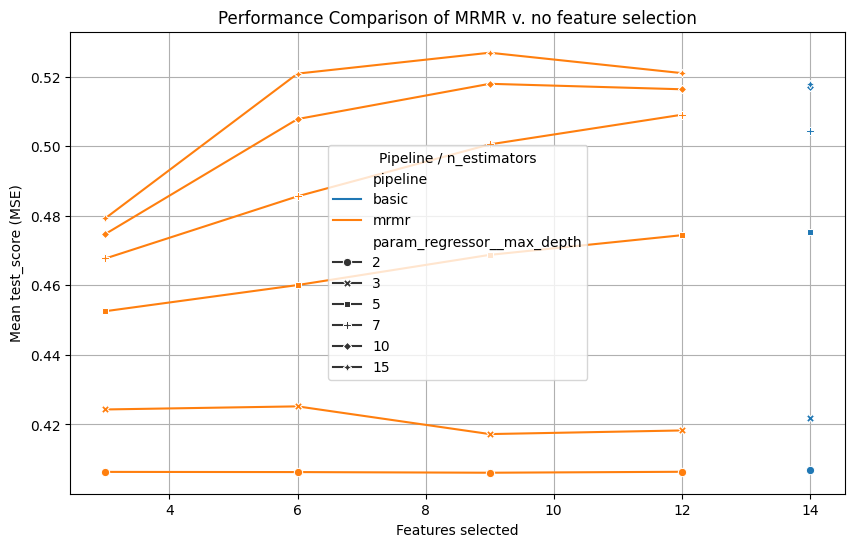

In [51]:
dff = cv[['pipeline', 'param_selector__n_features_to_select',
          'param_regressor__max_depth', 'mean_test_score']]

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=dff, x='param_selector__n_features_to_select', y='mean_test_score',
             hue='pipeline', style='param_regressor__max_depth', markers=True,
             dashes=False)

plt.xlabel('Features selected')
plt.ylabel('Mean test_score (MSE)')
plt.title('Performance Comparison of MRMR v. no feature selection')
plt.legend(title='Pipeline / n_estimators')
plt.grid(True)

# Show the plot
plt.show()

The 'basic' pipeline is represented by blue dots at number of features = 14. The MRMR pipeline, which varies depending on number of features selected as well as the random forest parameter `max_depth`, is in orange.

**For most of the models, MRMR succeeds in finding a set of 6 features that produce higher MSE compared to using all available features.**

It is notable that MRMR never provides an MSE bump for less complex models `max_depth = {2, 3}`. Its benefit becomes more pronounced as model complexity increases up to `max_depth = 15`.

## Classification with logistic regression

### Data

This dataset concerns the manufacturing of semiconductors, and is availabe from Kaggle: https://www.kaggle.com/datasets/paresh2047/uci-semcom/.

In [52]:
df = pd.read_csv('~/Downloads/uci-secom.csv')

# Relabel target column, drop time column
df = df.replace(to_replace=[-1, 1], value=[1, 0]) \
       .drop(['Time'], axis=1)

# Eliminate columns that have >50 missing values (~10% of total sample)
# leaving about 500 columns left
df = df.loc[:, df.isnull().sum() < 50]

df.head()

,0,1,2,3,4,5,6,7,8,9,...,577,582,583,584,585,586,587,588,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,14.9509,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,0
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,1


In [53]:
y = df['Pass/Fail']
X = df.drop('Pass/Fail', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1804)

### Pipeline without feature selection

This logistic regression uses all available features. K-nearest neighbors is chosen as an imputation strategy, and inputs are standardized.

In [54]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

basic_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(random_state=42))
])

param_grid_basic = {
    'regressor__max_iter': [500]
}

grid_search_basic = GridSearchCV(estimator=basic_pipeline, param_grid=param_grid_basic, cv=5,
                                 scoring='f1_weighted')

grid_search_basic.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('scaler', StandardScaler()),
                                       ('regressor',
                                        LogisticRegression(random_state=42))]),
             param_grid={'regressor__max_iter': [500]}, scoring='f1_weighted')

### Pipeline with MRMR feature selection

In [55]:
%%capture output

mrmr_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('selector', MRMRFeatureSelector(method='ftest')),
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(random_state=42))
])

param_grid_mrmr = {
    'selector__n_features_to_select': [10, 25, 50, 75, 100, 200, 300, 400, 500],
    'regressor__max_iter': [500]
}

grid_search_mrmr = GridSearchCV(estimator=mrmr_pipeline, param_grid=param_grid_mrmr, cv=5,
                                scoring='f1_weighted')

grid_search_mrmr.fit(X_train, y_train)

KeyboardInterrupt: 

### Examine results

In [ ]:
# Assemble CV
cv_basic = pd.DataFrame(grid_search_basic.cv_results_)
cv_basic['pipeline'] = 'basic'
cv_basic['param_selector__n_features_to_select'] = 530

cv_mrmr = pd.DataFrame(grid_search_mrmr.cv_results_)
cv_mrmr['pipeline'] = 'mrmr'

cv = pd.concat([cv_basic, cv_mrmr])

cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,pipeline,param_selector__n_features_to_select
0,0.214732,0.044933,0.056462,0.010084,500,{'regressor__max_iter': 500},0.898995,0.890915,0.874754,0.887756,0.893427,0.889169,0.008093,1,basic,530
0,0.229560,0.056455,0.042695,0.004178,500,"{'regressor__max_iter': 500, 'selector__n_feat...",0.899593,0.899593,0.899593,0.899197,0.899197,0.899435,0.000194,2,mrmr,10
1,0.290006,0.040109,0.046093,0.003865,500,"{'regressor__max_iter': 500, 'selector__n_feat...",0.899593,0.899593,0.899593,0.899197,0.899197,0.899435,0.000194,2,mrmr,25
2,0.438143,0.046798,0.044866,0.008814,500,"{'regressor__max_iter': 500, 'selector__n_feat...",0.899593,0.899593,0.899593,0.899197,0.899197,0.899435,0.000194,2,mrmr,50
3,0.647715,0.116834,0.039691,0.005121,500,"{'regressor__max_iter': 500, 'selector__n_feat...",0.899593,0.899593,0.899593,0.899197,0.899197,0.899435,0.000194,2,mrmr,75


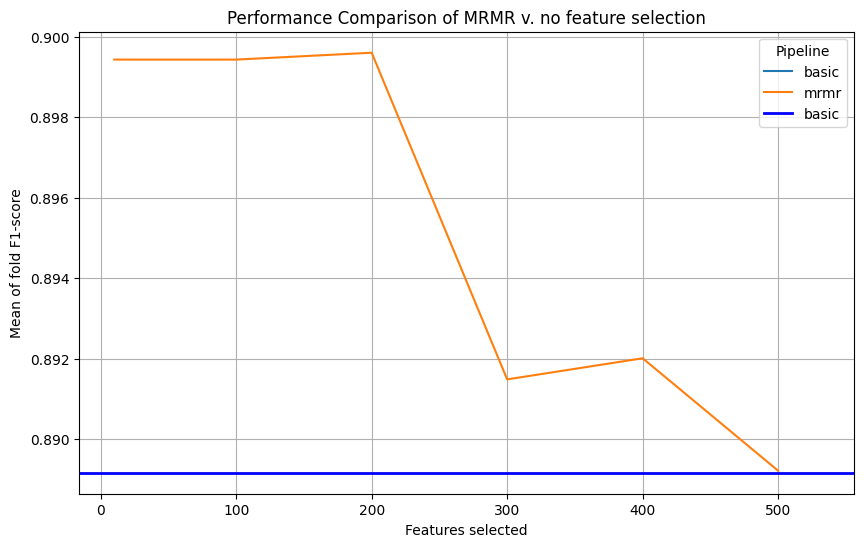

In [ ]:
dff = cv[['pipeline', 'param_selector__n_features_to_select', 'mean_test_score', 'std_test_score']]

basic_mean = dff.query('pipeline == "basic"')['mean_test_score'].values[0]

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=dff, x='param_selector__n_features_to_select', y='mean_test_score',
             hue='pipeline', markers=True, dashes=False)
plt.axhline(y=basic_mean, color='blue', linestyle='-', linewidth=2, label='basic')

plt.xlabel('Features selected')
plt.ylabel('Mean of fold F1-score')
plt.title('Performance Comparison of MRMR v. no feature selection')
plt.legend(title='Pipeline')
plt.grid(True)

# Show the plot
plt.show()

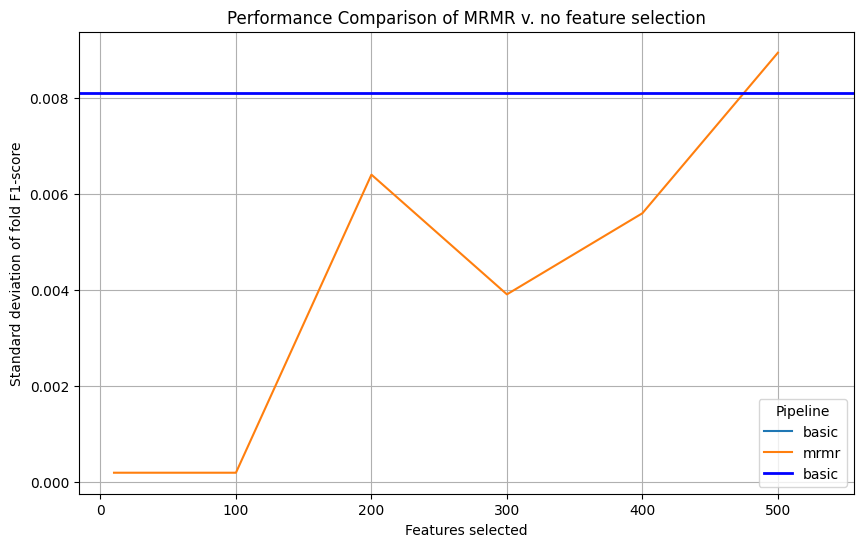

In [ ]:
basic_std = dff.query('pipeline == "basic"')['std_test_score'].values[0]

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=dff, x='param_selector__n_features_to_select', y='std_test_score',
             hue='pipeline', markers=True, dashes=False)
plt.axhline(y=basic_std, color='blue', linestyle='-', linewidth=2, label='basic')

plt.xlabel('Features selected')
plt.ylabel('Standard deviation of fold F1-score')
plt.title('Performance Comparison of MRMR v. no feature selection')
plt.legend(title='Pipeline')
plt.grid(True)

# Show the plot
plt.show()

The plots above show that MRMR did improve the overall performance of the model, although only slightly. However, the standard deviation of the test results show a distinct benefit to using MRMR. The pipeline without feature selection has almost 4 times the standard deviation as the MRMR pipeline with 100 features.